# Epiretinal Model Fitting Notebook

Contains code for Beyeler2019 like evaluation based on area, eccentricity, and orientation, as well as Granley2021 like evaluation for scaling amplitude, frequency, and pulse duration on data from Nanduri2012, Weitz2015, Horsanger2009, and Greenwald2009.
Beyeler code currently does not use leave on electrode out cross validation. It is just for evaluating

## Setup Code

In [1]:
import shapes
import pulse2percept as p2p
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.implants import ArgusII
from pulse2percept.utils import center_image, r2_score
from skimage import measure
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
h5_shapes = "/home/jgranley/shapes/data/shapes.h5"
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
### Helper class and functions to aggregate and plot results ###
class RegressionResults:
    def __init__(self, model=None, implant=None, name=None, subject=None):
        self.subject = subject
        self.model = model
        self.implant = implant
        self.name = name
        if self.name is None:
            self.name = str(model.__class__.__name__)
        
        # results (score or metric)
        self.results = {}
        # data on predictions vs true
        self.data = {}
        # any parameters used for the evaluation
        self.params = {}
        
    def add_results(self, runname, results, data, params):
        self.results[runname] = results
        self.data[runname] = data
        self.params[runname] = params
        
        
def plot_beyeler_percepts(results, vmax=1, annotate=True):
    """ assumes all results objects use the same data """
    if not isinstance(results, list):
        results = [results]
    runname = 'beyeler2019'
    for r in results:
        if runname not in r.data:
            raise ValueError()
    elecs = results[0].data[runname]['elecs']
    nrows = len(results) + 1
    ncols = results[0].data[runname]['elecs']
    ncols = min(len(elecs), 10)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    
    plotdata = [results[0].data[runname]['true']] + [r.data[runname]['preds'] for r in results]
    titles = ['True'] + [r.name for r in results]
    for idx_col in range(ncols):
        true_prop = plotdata[0]['props'][idx_col]
        for idx_row in range(nrows):
            ax = axes[idx_row, idx_col]
            plt.sca(ax)
            img = plotdata[idx_row]['percepts'][idx_col]
            if isinstance(img, p2p.percepts.Percept):
                img = img.max(axis='frames')
                img = p2p.utils.center_image(img)
            plt.imshow(img, cmap='gray', vmax=vmax)
            if idx_row == 0:
                plt.title(elecs[idx_col])
            if idx_col == 0:
                # electrode
                plt.ylabel(titles[idx_row])
            if annotate and idx_row == 0:
                plt.xlabel(f"a:{true_prop[0]:.0f} e:{true_prop[1]:.2f} o:{true_prop[2]:.2f}")
            elif annotate:
                diff = (plotdata[idx_row]['props'][idx_col] - true_prop) / true_prop * 100
                plt.xlabel(rf"$\Delta$ a:{diff[0]:.0f}% e:{diff[1]:.0f}% o:{diff[2]:.0f}%")
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['bottom'].set_color('gray')
            ax.spines['top'].set_color('gray')
            ax.spines['right'].set_color('gray')
            ax.spines['left'].set_color('gray')
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
    plt.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle("Scores: " + str([f"{r.results[runname]['score'] : .1f}" for r in results])) 
    # return fig
            
def plot_beyeler_props(results):
    if not isinstance(results, list):
        results = [results]
    nrows = len(results)
    ncols = 3
    names = ['Area', 'Eccentricity', 'Orientation']
    runname = 'beyeler2019'
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    for idx_row in range(nrows):
        for idx_col in range(ncols):
            if nrows > 1:
                ax = axes[idx_row, idx_col]
            else:
                ax = axes[idx_col]
            plt.sca(ax)
            res = results[idx_row].data[runname]
            true = res['true']['props']
            pred = res['preds']['props']
            p2p.viz.scatter_correlation(pred[:, idx_col], true[:, idx_col], show_slope_intercept=True, ax=ax)
            if idx_row == 0:
                plt.title(names[idx_col])
            if idx_col == 0:
                ylabel = results[idx_row].name + "\n"
            else:
                ylabel = ''
            ylabel += 'True'
            plt.ylabel(ylabel)
            plt.xlabel("Predicted")

            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
            plt.xlim(lim)
            plt.ylim(lim)
            plt.plot(lim, lim, linestyle=':', color='gray')

In [3]:
##### Beyeler 2019 evaluation #####           
def beyeler2019_eval(subject, implant, model, test_amps=[2.], data=None, resultsObj=None, thresh=1/np.exp(1)**2, dofit=False):
    """
    Returns:
    RegressionResults object
    """
    runname = 'beyeler2019'
    img_shape = None
    if data is None:
        data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    data = data[data.subject == subject]
    if test_amps is not None:
        data = data[data.amp1.isin(test_amps)]
    if not model.is_built:
        model.build()
    results = resultsObj
    if results is None:
        results = RegressionResults(model=model, implant=implant, subject=subject)
    elecs = data.electrode1.unique()
    
    # fit model if applicable
    if dofit and hasattr(model, 'fit') and callable(model.fit):
        model.fit(data)
    
    def get_prop(img):
        props = measure.regionprops(measure.label(img > thresh))
        class empty_prop:
            def __init__(self):
                self.area = -1
                self.orientation=-1
                self.eccentricity=-1
        if len(props) == 0:
            return empty_prop()
        return max(props, key = lambda x : x.area)
    
    true = {'percepts':[], 'props':[]}
    pred = {'percepts':[], 'props':[]}
    tot_time = 0
    for idx_elec, elec in enumerate(elecs):
        dfelec = data[data.electrode1 == elec]
        
        ## True
        true_perc = center_image(shapes.stack_phosphenes(dfelec).combined_image.iloc[0])
        
        true['percepts'].append(true_perc)
        # need to average props from each trial, not props from averaged percept
        trial_props = []
        
        for image in dfelec.image:
            if img_shape is None:
                img_shape = image.shape
            if image.shape != img_shape:
                image = resize(image, img_shape)
            prop = get_prop(image)
            trial_props.append([prop.area, prop.eccentricity, prop.orientation])
        true['props'].append(np.mean(trial_props, axis=0))
        
        ## Predicted
        stim = {elec : BiphasicPulseTrain(dfelec.freq.iloc[0], dfelec.amp1.iloc[0], dfelec.pdur.iloc[0])}
        implant.stim = stim
        if isinstance(model, p2p.models.AxonMapModel) or isinstance(model, p2p.models.ScoreboardModel):
            # axonmap tries to evaluate at every time point
            implant.stim = {elec : dfelec.amp1.iloc[0]}
        start = time.time()
        pred_perc = model.predict_percept(implant)
        tot_time += time.time() - start
        pred['percepts'].append(pred_perc)
        prop = get_prop(resize(pred_perc.max(axis='frames'), img_shape))

        pred['props'].append([prop.area, prop.eccentricity, prop.orientation])
        
    true['percepts'] = np.array(true['percepts'])
    true['props'] = np.array(true['props'])
    pred['percepts'] = np.array(pred['percepts'])
    pred['props'] = np.array(pred['props'])
    
    r2_scores = np.array([r2_score(true['props'][:, i], pred['props'][:, i]) for i in [0, 1, 2]])
    score = np.log(np.sum(1 - r2_scores))
    
    res = {'score':score, 'r2_scores':r2_scores, 'time':tot_time}
    dat = {'true':true, 'preds':pred, 'elecs':elecs}
    runparams = {'test_amps':test_amps, 'thresh':thresh}
    results.add_results(runname, res, dat, runparams)
    
    return results

## AxonMapModel

In [18]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=585, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.8, 1.4), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=24, noise=None, 
             retinotopy=Watson2014Map, rho=154, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             xrange=(-30, 30), xystep=0.25, 
             yrange=(-22.5, 22.5))

{'beyeler2019': {'score': 1.9468128029986795, 'r2_scores': array([-2.129, -1.848, -0.03 ]), 'time': 0.5435693264007568}}


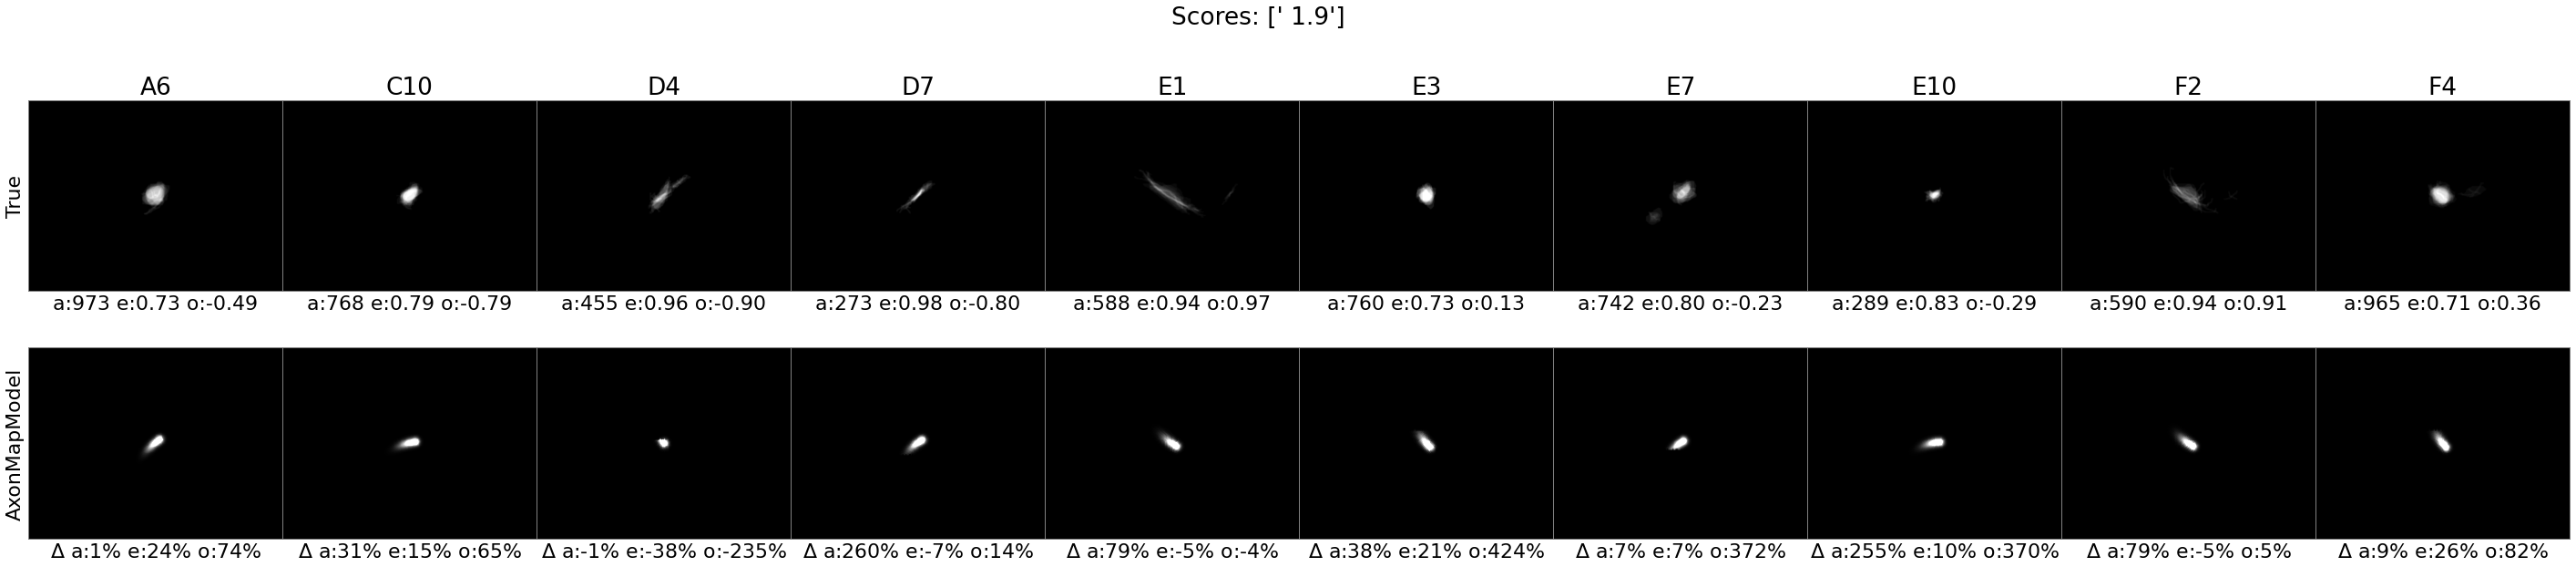

In [20]:
res = beyeler2019_eval(subject, implant, model, data=data)
print(res.results)
plot_beyeler_percepts(res)

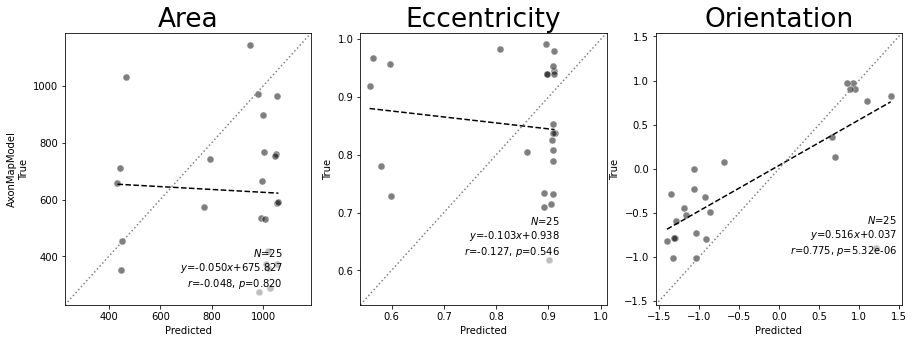

In [10]:
plot_beyeler_props(res)

In [4]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.rho = 100
model.axlambda = 585
model.build()
res = beyeler2019_eval(subject, implant, model)
print(res.results)

{'beyeler2019': {'score': 1.6189283461406982, 'r2_scores': array([-0.67, -1.5 ,  0.12]), 'time': 0.613060712814331}}


In [5]:
from scipy.optimize import minimize, differential_evolution

In [6]:

def opt_fn(params, subject='12-005'):
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.rho = params[0]
    model.axlambda = params[1]
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data)
    print(f"{res.results['beyeler2019']['score'] : .3f}")
    return res.results['beyeler2019']['score']

In [22]:
opt = minimize(opt_fn, [100, 585])

1.6189283461406982
1.6189283461406982
1.6189283461406982


In [24]:
opt

      fun: 1.6189283461406982
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([100., 585.])

In [16]:
def cb(xk, convergence=0.0):
    print(xk, convergence)

In [7]:
opts = []
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    def opt_fn(params):
        implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
        model.rho = params[0]
        model.axlambda = params[1]
        model.build()
        res = beyeler2019_eval(subject, implant, model, data=data)
        print(f"{res.results['beyeler2019']['score'] : .3f}")
        return res.results['beyeler2019']['score']
    opt = differential_evolution(opt_fn, [(20, 600), (25, 2000)], x0=[100, 585])
    opts.append(opt)
    print('---------------------------------------------------')

 1.619
 6.662
 6.682
 4.688
 2.714
 1.919
 5.347
 6.373
 6.115
 4.781
 6.253
 2.032
 2.566
 6.746
 4.807
 3.438
 6.080
 5.638
 6.282
 6.600
 4.706
 1.709
 4.490
 3.521
 4.598
 3.184
 1.713
 2.416
 1.730
 4.260
 2.061
 2.783
 4.868
 6.569
 5.195
 1.877
 4.347
 1.696
 3.457
 2.737
 6.127
 3.558
 3.241
 6.864
 4.297
 1.852
 5.939
 7.178
 5.939
 3.320
 6.216
 2.558
 1.864
 3.828
 1.687
 6.131
 3.911
 1.727
 1.655
 2.710
 4.732
 3.348
 1.784
 1.735
 3.286
 3.695
 2.457
 2.469
 3.047
 2.338
 1.885
 1.817
 1.994
 1.714
 2.309
 1.788
 3.385
 5.552
 3.355
 1.823
 1.969
 1.736
 1.634
 2.849
 1.923
 1.944
 1.717
 2.181
 1.831
 2.484
 1.798
 1.983
 3.341
 3.624
 1.568
 1.939
 1.727
 2.649
 1.673
 4.335
 1.621
 1.981
 1.691
 1.712
 1.644
 1.603
 2.099
 2.040
 1.734
 1.767
 2.356
 1.789
 2.374
 1.787
 1.709
 1.884
 1.624
 1.879
 3.432
 1.599
 1.564
 1.788
 1.683
 1.970
 1.846
 1.784
 1.653
 2.873
 1.900
 1.731
 1.714
 2.359
 1.563
 1.612
 1.651
 1.694
 3.648
 2.026
 1.635
 1.599
 1.736
 1.861
 2.217

In [9]:
for opt in opts:
    print(opt)

     fun: 1.5562400118520077
 message: 'Optimization terminated successfully.'
    nfev: 363
     nit: 11
 success: True
       x: array([119.72, 445.85])
     fun: 1.272087339997398
 message: 'Optimization terminated successfully.'
    nfev: 243
     nit: 7
 success: True
       x: array([ 157.63, 1249.21])
     fun: 2.3529348872724247
 message: 'Optimization terminated successfully.'
    nfev: 543
     nit: 17
 success: True
       x: array([ 22.32, 881.84])
